### 训练误差和泛化误差
> * 训练误差：模型在训练数据集上的误差
> * 泛化误差：模型在新数据集上的误差
### 验证数据集和测试数据集
> * 验证数据集：一个用来评估模型好坏的数据集，在训练过程中评估模型
> * 测试数据集：只用一次的数据集，发生在训练完成后，用来做模型最后的评估
### K-折交叉验证
> * 在没有足够多的数据时使用
> * 算法：
>> * 将训练数据分割成K块
>> * For i = 1, ..., K
>>> * 使用第i块作为验证数据集，其余的作为训练数据集
>> * 报告K个验证集误差的平均
> * 常用：K=5或K=10
### 总结
> * 训练数据集：训练模型参数
> * 验证数据集：选择模型超参数
> * 非大数据集上通常使用K-折交叉验证


---
|   |<font size=5>简单</font>|<font size=5>复杂</font>|
|---|---|---|
|<font size=5>低</font>|<font size=5>正常</font>|<font size=5>欠拟合</font>|
|<font size=5>高</font>|<font size=5>过拟合</font>|<font size=5>正常</font>|

### 数据复杂度
> * 多个重要因素
>> * 样本个数
>> * 每个样本的元素个数
>> * 时间、空间结构
>> * 多样性


In [8]:
import math 
import numpy as np
import torch
from torch import nn
from d2l import limutorch as d2l

### 使用以下三阶多项式来生成训练和测试数据的标签
> * $y = 5+1.2*x-3.4*\frac{x^2}{2!}+5.6*\frac{x^3}{3!}+\epsilon where \epsilon \sim N(0, 0.1^2)$

In [7]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
ploy_features = np.power(features, np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
  ploy_features[:, i] /= math.gamma(i+1)
labels = np.dot(ploy_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [10]:
true_w, features, ploy_features, labels = [
    torch.tensor(x, dtype = torch.float32)
    for x in [true_w, features, ploy_features, labels]]

"""查看前两个样本"""
features[:2], ploy_features[:2,:],labels[:2]

(tensor([[-1.1174],
         [ 0.3498]]),
 tensor([[ 1.0000e+00, -1.1174e+00,  6.2428e-01, -2.3252e-01,  6.4955e-02,
          -1.4516e-02,  2.7033e-03, -4.3153e-04,  6.0273e-05, -7.4832e-06,
           8.3616e-07, -8.4938e-08,  7.9091e-09, -6.7981e-10,  5.4258e-11,
          -4.0419e-12,  2.8227e-13, -1.8553e-14,  1.1517e-15, -6.7734e-17],
         [ 1.0000e+00,  3.4984e-01,  6.1195e-02,  7.1363e-03,  6.2414e-04,
           4.3670e-05,  2.5463e-06,  1.2726e-07,  5.5651e-09,  2.1632e-10,
           7.5679e-12,  2.4069e-13,  7.0170e-15,  1.8883e-16,  4.7187e-18,
           1.1005e-19,  2.4064e-21,  4.9521e-23,  9.6247e-25,  1.7722e-26]]),
 tensor([0.2305, 5.2702]))

In [22]:
"""实现一个函数来评估模型在给定数据集上的损失"""
def evaluate_loss(net, data_iter, loss):
  """评估给定数据集上模型的损失"""
  metric = d2l.Accumulator(2)
  for X, y in data_iter:
    out = net(X)
    y = y.reshape(out.shape)
    l = loss(out, y)
    metric.add(l.sum(), l.numel())
  return metric[0] / metric[1]

In [28]:
"""定义训练函数"""
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
  loss = nn.MSELoss()
  input_shape = train_features.shape[-1]
  net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
  batch_size = min(10, train_labels.shape[0])
  train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
  test_iter = d2l.load_array((test_features, test_labels.reshape([-1,1])), batch_size, is_train=False)
  trainer = torch.optim.SGD(net.parameters(), lr=0.01)
  animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', 
              xlim=[1,num_epochs], ylim=[1e-3,1e2], legend=['train','test'])
  for epoch in range(num_epochs):
    d2l.train_epoch_ch3(net, train_iter, loss, trainer)
    if epoch == 0 or (epoch+1) % 20 == 0:
      animator.add(epoch+1, (evaluate_loss(net, train_iter, loss),
                  (evaluate_loss(net, test_iter, loss)))) 
  print('weight:',net[0].weight.data.numpy())

weight: [[ 5.014475   1.2072532 -3.403094   5.576863 ]]


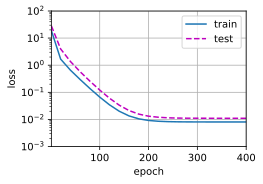

In [33]:
"""三阶多项式函数拟合（正态）"""
train(ploy_features[:n_train, :4], ploy_features[n_train:,:4], labels[:n_train], labels[n_train:])

weight: [[3.2734091 3.627799 ]]


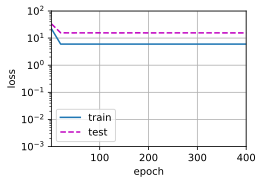

In [30]:
"""线性函数拟合（欠拟合）"""
train(ploy_features[:n_train, :2], ploy_features[n_train:,:2], labels[:n_train], labels[n_train:])

weight: [[ 4.963503    1.3081897  -3.2177157   4.990973   -0.45132652  1.597023
  -0.05058232  0.36019346  0.08891987 -0.03157202 -0.07159203 -0.18428378
  -0.021332    0.03107644 -0.02138317  0.16410026 -0.05794277 -0.14903685
  -0.06332668  0.12817746]]


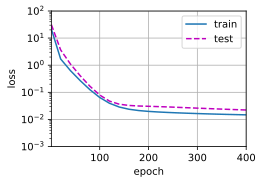

In [32]:
"""高阶多项式函数拟合（过拟合）"""
train(ploy_features[:n_train, :], ploy_features[n_train:, :], labels[:n_train], labels[n_train:])